## Algoritmo genético

In [2429]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import random
from sympy import symbols, sympify, lambdify
import time
import copy


In [2430]:
doc2 = open("C:/Users/antoc/Downloads/PortableGit/practica2024/hub_data.txt")
lineas2 = doc2.readlines()

H_0= 70

# Divide cada línea en columnas usando espacio como separador
datos_separados2 = [linea.strip().split(' ') for linea in lineas2]

datos= []
for fila in datos_separados2:
    datos.append(fila)

z = []
for i in range(len(datos)):
      a = float(datos[i][0])
      z.append(a)
z =np.array(z)

H = []
for i in range(len(datos)):
   if datos[i][1] == '':
      a = float(datos[i][2])
      H.append(a)
   else:
      a = float(datos[i][1])
      H.append(a)
H = np.array(H)

desv = []
for i in range(len(datos)):
    a = float(datos[i][2])
    desv.append(a)


Se minimiza $$\chi^2 = \sum_{i=1}^{N} (\dfrac{y_i - f(x_i)}{\sigma_{i}})^2$$ para obtener la función $f(x)$ que mejor se ajuste a los datos.


In [2431]:
def expo(x):
    return np.exp(x)
def ln(x):
    return np.log(x)
def poli1(x):
    return x 
def poli2(x):
    return x**2
def poli3(x):
    return x**3

grammar = [expo, ln, poli1, poli2, poli3]
operaciones = ['+', '-', '*', '/']

#A partir de las funciones ingresadas inicialmente, calcula el chi_2
def chi_2_valores(f):
    return np.square((H - f(z))/desv)

def chi_2_f(f):
    chi_2_val = np.zeros_like(f)
    chi_2 = np.zeros_like(f)
    for i in range(len(f)):
        chi_2_val[i] = chi_2_valores(f[i])
        for j in range(len(chi_2_val)):
            chi_2[j] = np.sum(chi_2_val[j])
    
    return chi_2

print(chi_2_f(grammar))
chi_inic = chi_2_f(grammar)

[4157.01591713639 4430.910574765109 4318.165617110693 4300.926784511239
 4239.109972002022]


### Combinar la función inicial
Se combinan las funciones iniciales con operaciones entre ellas hasta que sean 1000 funciones iniciales.

In [2432]:
def juntar_elementos_inicial(funciones, operaciones, longitud_final=1000):
    final = []
    while len(final) < longitud_final * 3:
        random_funcion1 = random.choice(funciones)
        random_funcion2 = random.choice(funciones)
        random_operador = random.choice(operaciones)

        final.append(random_funcion1)
        final.append(random_operador)
        final.append(random_funcion2)

    # Crear una lista de sublistas para representar las filas
    resultado_final_inicial = [final[i:i+3] for i in range(0, len(final), 3)]

    return resultado_final_inicial

resultado_final_inicial = juntar_elementos_inicial(grammar, operaciones)

#for fila in resultado_final_inicial:
#    print(fila)



### Convertir la lista a función
Se definen funciones para para convertir una lista de funciones y strings (operaciones) en una función.

In [2433]:

#x deben estar entre paréntesis para no confundir con otros x en el string
def a_string(funcion):
    if funcion == expo:
        return 'exp(x)'
    elif funcion == ln:
        return 'log(x)'
    elif funcion == poli1:
        return '(x)'
    elif funcion == poli2:
        return '(x)**2'
    elif funcion == poli3:
        return '(x)**3'
    else:
        return str(funcion)

x = symbols('x')
def pasar_a_funcion(expresion):
    a_sympy = sympify(expresion)
    a_python = lambdify(x, a_sympy, 'numpy')
    return a_python

#print(pasar_a_funcion('exp(x**2)'))(2)
def composicion(lista):
    modi_int = a_string(lista[-1])
    #print(modi_int)
    for i in range(2,len(lista)+1):
        modi_ext = a_string(lista[-i])
        modi_int = modi_ext.replace('(x)', '('+ modi_int +')' )
    return modi_int

print(composicion([expo, ln, poli2]))

def convertir_lista_a_str(lista):
    string=''
    for i in range(len(lista)):
        if callable(lista[i]):
            if i != 0 and callable(lista[i - 1]):
                string = string
            elif i < len(lista) - 1 and callable(lista[i + 1]):
                compo = []
                for j in range(i, len(lista)):
                    if callable(lista[j]):
                        compo.append(lista[j])

                string += composicion(compo)
            
            else:  
                string += a_string(lista[i])
        else:
            string += lista[i]

    return string

#lista_prueba = [poli2, '+', poli1,'-', expo, ln, poli2 ,'-', poli1]
#funcion_prueba= convertir_lista_a_str(lista_prueba)
#print(funcion_prueba)

def convertir_lista_a_funcion(lista):
    string = convertir_lista_a_str(lista)
    func= pasar_a_funcion(string)
    return func

#print(convertir_lista_a_funcion(lista_prueba))


exp(log((x)**2))


### Calcular los $\chi^2$ de la población inicial y seleccionar las mejores funciones

In [2434]:
def mejores(resultado_final, tasa_seleccion = 0.2):
    chis =[]
    for fila in resultado_final:
        a = [convertir_lista_a_funcion(fila)]
        chi_combinaciones = chi_2_f(a)
        chis.append(chi_combinaciones)

    #print(chis)

    ''' 
    Se seleccionan elementos a combinar
    '''

    cant_sobrevivientes = tasa_seleccion*len(chis)
    cant_sobreviv = int(cant_sobrevivientes)
    #print('Cantidad de sobrevientes:' , cant_sobreviv)

    # Número de elementos más pequeños
    num_elementos = cant_sobreviv
    # Obtener los índices y valores de los elementos más pequeños en orden
    indices_valores_menores = sorted(enumerate(chis), key=lambda x: x[1])[:num_elementos]
    # Separar los índices y valores en listas distintas
    indices_menores, valores_menores = zip(*indices_valores_menores)
    print("Valores de chi de los elementos más pequeños:", valores_menores)


    f_mejores= []
    for numero in indices_menores:
        f_mejores.append(resultado_final[numero])

    return f_mejores

#mejores(resultado_final_inicial)


### Crossover
Combinar random partes de las soluciones de los padres (composición de funciones y sumar, multiplicar... una con otra).
La selección sirve para dejar pasar un cierto porcentaje, los cuales tendrán que acoplarse y mutar. O sea, el número baja con la selección pero aumenta con el crossover y mutación. Para cada elemento del crossover, salen 3 hijos que son producto de combinaciones con otros padres.

In [2435]:
def crossover(padres):
    #El primer elemento se mantiene constante (mejor chi^2)
    hijos = []
    hijos.append(padres[0])
    for i in range(1, len(padres)):

        #Elegir 3 funciones al azar de las mejores ya escogidas
        combinar1 = random.choice(padres)
        combinar2 = random.choice(padres)
        combinar3 = random.choice(padres)

        # Separar funciones de operaciones para cada función que se combina con la seleccionada
        funciones_combinar1 = []
        for j in range(len(combinar1)):
            if callable(combinar1[j]):  # Verificar si es una función
                funciones_combinar1.append(combinar1[j])
        combinar_con1 = random.choice(funciones_combinar1) #Elegir una función de las disponibles

        funciones_combinar2 = []
        for j in range(len(combinar2)):
            if callable(combinar2[j]):  # Verificar si es una función
                funciones_combinar2.append(combinar2[j])
        combinar_con2 = random.choice(funciones_combinar2) #Elegir una función de las disponibles

        funciones_combinar3 = []
        for j in range(len(combinar3)):
            if callable(combinar3[j]):  # Verificar si es una función
                funciones_combinar3.append(combinar3[j])
        combinar_con3 = random.choice(funciones_combinar3) #Elegir una función de las disponibles

        # Crear copias de los padres para modificar
        hijos1 = copy.deepcopy(padres[i])
        hijos2 = copy.deepcopy(padres[i])
        hijos3 = copy.deepcopy(padres[i])

        # Agregar operador y función combinada a cada hijo
        numero_random1 = random.randint(0,1)
        if numero_random1 == 0:
            random_operador1 = random.choice(operaciones)
            hijos1.append(random_operador1)
            hijos1.append(combinar_con1)
        else:
            hijos1.append(combinar_con1)

        numero_random2 = random.randint(0,1)
        if numero_random2 == 0:
            random_operador2 = random.choice(operaciones)
            hijos2.append(random_operador2)
            hijos2.append(combinar_con2)
        else:
            hijos2.append(combinar_con2)

        numero_random3 = random.randint(0,1)
        if numero_random3 == 0:
            random_operador3 = random.choice(operaciones)
            hijos3.append(random_operador3)
            hijos3.append(combinar_con3)
        else:
            hijos3.append(combinar_con3)

        # Agregar los hijos a la lista final
        hijos.extend([hijos1, hijos2, hijos3])
    #print(hijos)
    return hijos
    
#crossover(mejores(resultado_final_inicial))
#len(crossover(mejores(resultado_final_inicial)))

### Mutación
tasa de mutación: 5, 10 % 
cambiar una parte random de las funciones

In [2436]:
def mutar(padres, tasa_mutacion= 0.05):
    hijos = copy.deepcopy(padres)
    for lista in hijos:
        #Se deja constante 1 elemento
        for i in range(1, len(lista)):
            # Genera un número aleatorio entre 0 y 1
            probabilidad = random.random()

            # Verifica si el número aleatorio es menor que la probabilidad deseada
            if probabilidad < tasa_mutacion:
                if callable(lista[i]):
                    lista[i] = random.choice(grammar)
                else:
                    lista[i] = random.choice(operaciones)
    return hijos

### Recurrencia

In [2437]:
poblacion_inicial = resultado_final_inicial

# Medir el tiempo de ejecución de la función
inicio_tiempo = time.time()  # Obtiene el tiempo actual

# Mejores funciones de la población inicial
mejores_inicial = mejores(poblacion_inicial)
while len(mejores_inicial) >= 5:
    # Aplicar crossover y mutación a la población actual
    mutar(crossover(mejores_inicial))
    
    # Obtener las mejores funciones de la población mejorada
    mejores_actual = mejores(mutar(crossover(mejores_inicial)))
    mejores_inicial = mejores_actual
    
    mejores_str = []
    for i in range(len(mejores_actual)):
        mejores_str.append(convertir_lista_a_str(mejores_actual[i]))

    print(f"Mejores funciones en esta iteración: {mejores_str}")
    #print(f"Chi^2: {chis}")
    print(f"Len mejores funciones en esta iteración: {len(mejores_str)}")

fin_tiempo = time.time()  # Obtiene el tiempo después de la ejecución

tiempo_total = fin_tiempo - inicio_tiempo
print(f"El tiempo de ejecución fue: {tiempo_total} segundos")

Valores de chi de los elementos más pequeños: (array([3374.6766209415773], dtype=object), array([3374.6766209415773], dtype=object), array([3374.6766209415773], dtype=object), array([3374.6766209415773], dtype=object), array([3374.6766209415773], dtype=object), array([3374.6766209415773], dtype=object), array([3374.6766209415773], dtype=object), array([3374.6766209415773], dtype=object), array([3374.6766209415773], dtype=object), array([3374.6766209415773], dtype=object), array([3387.2810867675166], dtype=object), array([3387.2810867675166], dtype=object), array([3387.2810867675166], dtype=object), array([3387.2810867675166], dtype=object), array([3387.2810867675166], dtype=object), array([3387.2810867675166], dtype=object), array([3387.2810867675166], dtype=object), array([3387.2810867675166], dtype=object), array([3387.2810867675166], dtype=object), array([3387.2810867675166], dtype=object), array([3387.2810867675166], dtype=object), array([3449.937770291242], dtype=object), array([3

<lambdifygenerated-788697>:2: RuntimeWarning: overflow encountered in exp
  return (x**3*exp(exp(x**3)))


Valores de chi de los elementos más pequeños: (array([2663.2159968011797], dtype=object), array([2864.7062590747114], dtype=object), array([3043.396556666684], dtype=object), array([3045.6857062231265], dtype=object), array([3069.9349063223963], dtype=object), array([3087.4802940219643], dtype=object), array([3115.547125277514], dtype=object), array([3130.236388900095], dtype=object), array([3135.1432680669923], dtype=object), array([3162.2001655397607], dtype=object), array([3174.0169691536435], dtype=object), array([3194.6108163666095], dtype=object), array([3195.247632165325], dtype=object), array([3195.247632165325], dtype=object), array([3201.04052740801], dtype=object), array([3206.7046237846303], dtype=object), array([3228.3715543479602], dtype=object), array([3228.3715543479602], dtype=object), array([3228.3715543479602], dtype=object), array([3238.8919355887033], dtype=object), array([3240.6695257656834], dtype=object), array([3240.6695257656834], dtype=object), array([3247.13

<lambdifygenerated-788871>:2: RuntimeWarning: overflow encountered in exp
  return (x**6 + exp(exp(exp(x))))
<lambdifygenerated-788983>:2: RuntimeWarning: overflow encountered in exp
  return (x**3*exp(exp(x**3)) + x**3 + x)
<lambdifygenerated-789096>:2: RuntimeWarning: overflow encountered in exp
  return (2*exp(x) + exp(2*exp(3*x)))
<ipython-input-2431-2cd2a96c727e>:17: RuntimeWarning: overflow encountered in square
  return np.square((H - f(z))/desv)


Valores de chi de los elementos más pequeños: (array([2381.1902239994442], dtype=object), array([2488.4870174818257], dtype=object), array([2498.466835338914], dtype=object), array([2645.8620979023367], dtype=object), array([2663.2159968011797], dtype=object), array([2688.9404287525563], dtype=object), array([2891.534584025182], dtype=object), array([2934.1029139853936], dtype=object), array([2934.1029139853936], dtype=object), array([3027.073850675626], dtype=object), array([3040.7308572037796], dtype=object), array([3043.396556666684], dtype=object), array([3043.396556666684], dtype=object), array([3068.7433026809877], dtype=object), array([3105.7405823215886], dtype=object), array([3108.9605634160603], dtype=object), array([3116.2625986163525], dtype=object), array([3116.2625986163525], dtype=object), array([3135.1432680669923], dtype=object), array([3144.203779723962], dtype=object), array([3157.3759904818294], dtype=object), array([3157.3759904818294], dtype=object), array([3159.6

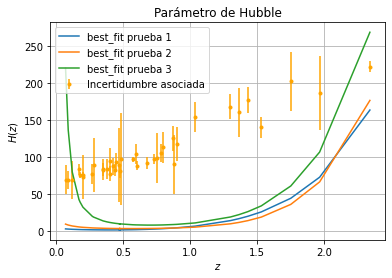

In [2438]:
def prueba1(x):
    return x**3 + expo(x) * x**3 + x**2 + x**3 - ln(x)

def prueba2(x):
    return (x)**3*(x)**3+expo(x)/expo(x)+expo(x)-ln(x)+ln(x)*ln(x)+ln(x)
 
def prueba3(x):
    return expo(x)*expo(x)+expo(x)/(x)**2+(((((x)))**2)**3)-(x)*(x)

yerr = desv
plt.xlabel('$ z $')
plt.ylabel('$ H(z) $')
plt.title('Parámetro de Hubble')

plt.plot(z, prueba1(z), label= 'best_fit prueba 1')
plt.plot(z, prueba2(z), label= 'best_fit prueba 2')
plt.plot(z, prueba3(z), label= 'best_fit prueba 3')

plt.errorbar(z, H, yerr=yerr, fmt='.', color = 'orange', label = 'Incertidumbre asociada')
plt.legend()
plt.grid(True)
plt.show()